# Exercises: Working with the Microphone

In this notebook, we will learn how to access the digitized audio recording our microphones, and access the audio samples as a numpy array of data that we can analyze and manipulate.
We will write functions for writing and reading our own numpy-based audio files.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from typing import Tuple

%matplotlib notebook

<!-- #region -->
As discussed in the [preceding section](https://rsokl.github.io/CogWeb/Audio/digitizing_signals.html), a microphone is responsible for converting the information carried by sound waves into an analog electrical signal, which it then digitizes through a process comparable to pulse code modulation (PCM). 
Let's take some time to understand how we can access the digital audio samples that are recorded by your microphone. 

Your microphone stores the audio on buffer frames, which is just an area of RAM made for temporary storage.
Buffers are typically used when there is a difference between the rate at which data is received and the rate at which it can be processed.
The details of buffer frames are not especially important though.
We only need to know that our digital signal will be stored as a collection of bytes in memory across a number of frames.

## Using the Microphone Python Package
The `microphone.record_audio` package records and digitizes an analog signal and returns a tuple containing 

1. a list of bytes in memory corresponding to the digital signal 
2. the sampling rate.

(Remember that, in a Jupyter Notebook, you can check this by inspecting the function's docstring with `SHIFT-TAB`)

For example, consider the following code

In [2]:
from microphone import record_audio
listen_time = 5  # seconds
frames, sample_rate = record_audio(listen_time)

No microphone configuration file found, attempting to find default device..
Using input device 'Microphone Array (Realtek High '
Recording ended


Here `sample_rate` is the sampling rate, $f_s$, used by the microphone to record the digital signal.
Since all we need to know in order to reconstruct the original signal from bytes in memory are the sampling rate and the number of samples, it is extremely important that we keep track of `sample_rate`!

The `frames` variable is a list of bytes in memory that compose the entirety of the recorded digital signal.
To anyone except a computer, the elements of `frames` are indecipherable;
just try inspecting `frames[0]`.

To make the data useful to us, we will need to convert each of the bytes into $16$-bit integers, under the assumption that the microphone used the standard bit depth of $N_b=16$.
To do so, we can use the [numpy.frombuffer](https://numpy.org/doc/1.18/reference/generated/numpy.frombuffer.html) function. In particular,

In [3]:
np.frombuffer(frames[0], np.int16)

array([ 0,  0, -1, ..., 61, 64, 62], dtype=int16)

will read in the first frame and return a 1-D NumPy array containing $16$-bit integers.
In order to convert the entire digital signal into readable integers, we will need to iterate over each frame in `frames` and use `np.frombuffer(..., np.int16)` to convert each "frame" of bytes into an array of 16-bit integers.
We can then use the [numpy.hstack](https://numpy.org/doc/1.18/reference/generated/numpy.hstack.html) function to join all of these arrays together into a single array of all of 16-bit integers that make up the digital audio recording:

In [5]:
# Converting bytes of memory that was written to by our microphone
# into a single array of 16-bit integers.
# This array stores the digital audio data of our recording

samples = np.hstack([np.frombuffer(i, np.int16) for i in frames])

<!-- #endregion -->

(1.2.1) Use the `record_audio` function to record and digitize an analog signal that lasts one second.
Then iterate through each frame and convert the bytes into NumPy arrays of $16$-bit integers.
Finally, concatenate all the NumPy arrays in order to have a single array corresponding to the full digital signal.
[List comprehensions](https://www.pythonlikeyoumeanit.com/Module2_EssentialsOfPython/Generators_and_Comprehensions.html#List-&-Tuple-Comprehensions) using [numpy.hstack](https://numpy.org/doc/1.18/reference/generated/numpy.hstack.html).

In [9]:
from microphone import record_audio

listen_time = 3  # seconds
frames, sample_rate = record_audio(listen_time)

samples = np.hstack([np.frombuffer(i, np.int16) for i in frames])


No microphone configuration file found, attempting to find default device..
Using input device 'Microphone Array (Realtek High '
Recording ended


You can listen to the audio samples are stored in the resulting NumPy array (_not_ the memory frames) using

In [10]:
# Listen to your recording 
Audio(samples, rate=sample_rate)

Now that we have made our digital signal a bit more useful, let's save our digital signal so we can work with it even when we need to restart our Jupyter Notebook kernel.
Thankfully NumPy provides us with the capability to save arrays to disk (as `npy` files) with the [numpy.save](https://numpy.org/doc/1.18/reference/generated/numpy.save.html) function.


## Writing Our Own Audio Files (Using NumPy)


(1.2.2) Write a function that records an analog signal and [writes the resulting digital signal to a](https://www.pythonlikeyoumeanit.com/Module5_OddsAndEnds/WorkingWithFiles.html#Saving-and-Loading-NumPy-Arrays) `npy` file.
Remember that we will also want to save the sampling rate of the digital signal, so make the array you save have as its first element the sampling rate.
In other words, `array_to_save[0] == sample_rate` and `array_to_save[1] == samples[0]`.
This additional information that we save are saving to the beginning of our array, to provide context for interpreting the rest of the data in the array, is often referred to as a "file header".

An important note: we converted the bytes in the buffer frames into signed $16$-bit integers. However, the standard sampling rate of $44,100\:\mathrm{Hz}$ cannot be stored as a signed $16$-bit integer (the largest signed 16-bit integer is $\pm 32,768$), meaning that in order to store `sample_rate` alongside `samples`, `array_to_save` must store $32$-bit integers instead of $16$-bit integers.

In [11]:
def record_and_save(listen_time: float, file_path: str):
    """
    Uses microphone to record and digitize an analog signal 
    and save the resulting digital signal and sampling rate to npy file.
    
    The first element in the saved array should store the the sample-rate;
    the remaining elements in the array should store the sampled data itself.
    
    
    Parameters
    ----------
    listen_time : float
        Length of recording in seconds.
        
    file_path : Union[str, pathlib.Path]
        Path to the file destination. E.g. "my_audio.npy" will save an audio
        file called "my_audio.npy" to the current working directory.
    """

    frames, sample_rate = record_audio(listen_time)

    samples = np.hstack([np.frombuffer(i, np.int16) for i in frames])
    array_to_save = np.hstack((sample_rate, samples))

    np.save(file_path, array_to_save)


(1.2.3) Now that we've devised a way to record and save a digital signal to a file, we need a way to load that file.
Write a function that loads a digital signal saved by your previous function. It should return a tuple containing

1. the NumPy array storing the digital signal
2. the sampling rate of the signal.

The function [numpy.load](https://numpy.org/doc/1.18/reference/generated/numpy.load.html) will be handy here.

In [13]:
def load_and_parse(file_path: str) -> Tuple[np.ndarray, int]:
    """
    Loads a saved digital signal from an npy file and returns the signal and the sampling rate.
    
    Parameters
    ----------
    file_path : Union[str, pathlib.Path]
        Path to the numpy-based audio file (.npy) to be loaded
        
    Returns
    -------
    Tuple[np.ndarray, int]
        The digital signal as a NumPy array and the sampling rate
    """
    
    loaded_array = np.load(file_path)
    
    sample_rate = loaded_array[0]
    signal = loaded_array[1:]
    
    return signal, sample_rate


Use these functions to record a $2$ second recording and save a digital audio file.
Then load the signal and sample rate from the audio file.

In [24]:
# STUDENT CODE
file_path = 'Music\class_sample.npy'
record_and_save(3,file_path=file_path)
samples,sample_rate = load_and_parse(file_path)

No microphone configuration file found, attempting to find default device..
Using input device 'Microphone Array (Realtek High '
Recording ended


Listen to your recording: 

In [25]:
Audio(samples, rate=sample_rate) 

## Visualizing an Audio Recording


(1.2.4) Now that we can read the digital signal back into Python, let's determine the times at which the analog signal was sampled.
Remember, we only need to know two things to do this, the number of samples ($N$) and the sampling rate ($f_s$).

Define the variable `times` – a NumPy array containing the times at which the analog signal was sampled.
The size of `times` should be the same as the size of the array containing the digital signal, and the final value in `times` (i.e. `times[-1]`) should be very close the initial recording length.

In [26]:
# STUDENT CODE
times = np.arange(samples.size) / sample_rate

(1.2.5) Finally, let's plot our digital signal.
First, plot the digital signal recorded by the computer.
Then, plot every $441^\text{st}$ sample of the digital signal;
assuming the original sampling rate is the standard $f_s=44,100 \:\mathrm{Hz}$, this signal would correspond to the case where we had used a sampling rate of only $f_s=100\:\mathrm{Hz}$.

Think about how we can create this low-rate, re-sampled signal by simply slicing into our original signal.

Label your axes and include units. The values that you recorded in your microphone aren't direct voltage measurements, but they are proportional to it – suffice it to label the $y$-axis as `"Proportional to Volts"`

<IPython.core.display.Javascript object>


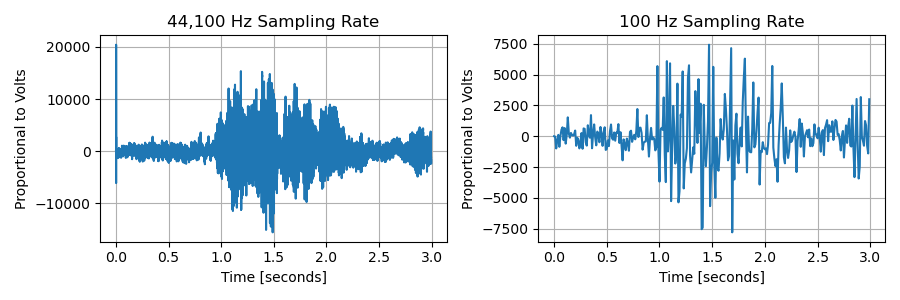

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))

axs[0].plot(times, samples)
axs[0].set_title("44,100 Hz Sampling Rate")
axs[0].set_xlabel("Time [seconds]")
axs[0].set_ylabel("Proportional to Volts")
axs[0].grid(True)


#STUDENT CODE - use slicing to complete the next two lines: 
low_sampled_times = times[::int(sample_rate/100)]
low_sampled_samples = samples[::int(sample_rate/100)]


axs[1].plot(low_sampled_times, low_sampled_samples)
axs[1].set_title("100 Hz Sampling Rate")
axs[1].set_xlabel("Time [seconds]")
axs[1].set_ylabel("Proportional to Volts")
axs[1].grid(True)

fig.tight_layout()
